In [29]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import trange

import sys
sys.path.append("../")
from models import ResNet18
from helpers import get_model_size, estimate_loss, normalize_tensor, CiFaData

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
EPOCHS = 110
BATCH_SIZE = 512
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

In [19]:
# we actually just need it to download cifar dataset
# torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
# torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

tf = transforms.Compose([transforms.RandomCrop(32, padding=4), 
                         transforms.RandomHorizontalFlip(p=0.58),
                         transforms.RandomErasing()])
                        #  transforms.RandomRotation(10)])
                        #  transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
                        #  transforms.RandomAffine(degrees=90)]) 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# create loader to get the params
# complete_ds = CiFaData(stage="all")
# big_loader = DataLoader(complete_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14)
# params = get_parameters(big_loader)

params = torch.tensor([0.4919, 0.4827, 0.4472]), torch.tensor([0.2470, 0.2434, 0.2616])
print(f"normalized parameters of the dataset: {params}")

train_ds = CiFaData(stage="train", path='../data/', transform=tf, dataset_params=params)
val_ds = CiFaData(stage="val", path='../data/', dataset_params=params)
test_ds = CiFaData(stage="test", path='../data/', dataset_params=params)

# pinning memory, takes cpu data and pins it to the gpu.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=14, pin_memory=True) 
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)

normalized parameters of the dataset: (tensor([0.4919, 0.4827, 0.4472]), tensor([0.2470, 0.2434, 0.2616]))


ResNet 18

model size: 18.756 MB


epoch 110 | training loss: 0.2380 | validation loss: 0.465924 | current lr: 0.000001 | validation accuracy: 0.86: 100%|██████████| 110/110 [03:04<00:00,  1.68s/it]


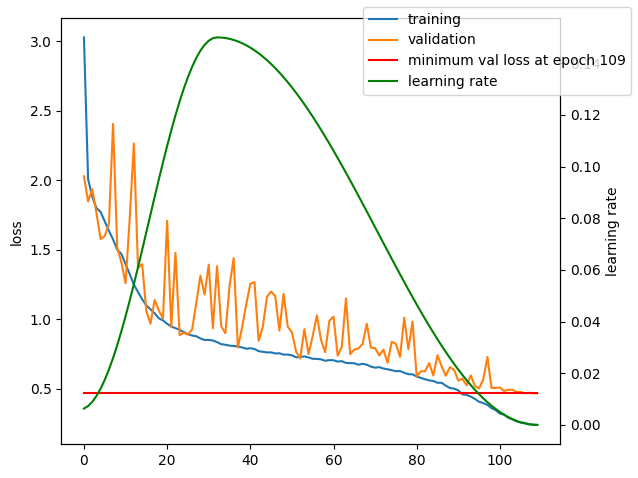

In [100]:
model = ResNet18()
model.init_weights()
model.to(device)

# optimizer = optim.AdamW(params=[p for p in model.parameters() if p.requires_grad==True], lr=LR)
optimizer = optim.SGD(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
# the initial lr is calculated instead of taken from optim: max_lr / div_factor
scheduler = lr_scheduler.OneCycleLR(optimizer=optimizer, steps_per_epoch=int(train_loader.__len__()),
                                    epochs=EPOCHS, max_lr=0.15, anneal_strategy='cos')#, three_phase=True, final_div_factor=1000)

criterion = nn.CrossEntropyLoss()
model_size = get_model_size(model)

# training loop
losses = []
val_losses = []
all_the_lrs = []
lrs = []

for epoch in (t:=trange(EPOCHS)):
  model.train()
  running_loss = []
  for step, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
    predictions = model(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    all_the_lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step() # with the onecycle scheduler, we step after every batch
    running_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(running_loss))
  val_loss, val_acc = estimate_loss(model, val_loader, criterion, device)
  val_losses.append(val_loss)
  # scheduler.step(metrics=val_loss)
  # if epoch in schedule.keys():
  #   optimizer.param_groups[0]['lr'] = schedule[epoch]
  lrs.append(optimizer.param_groups[0]['lr'])
  t.set_description(f"epoch {epoch+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.6f} | current lr: {lrs[-1]:.6f} | validation accuracy: {val_acc:.2f}")

fig, ax1 = plt.subplots()
ax1.plot(range(EPOCHS), losses, label='training')
ax1.plot(range(EPOCHS), val_losses, label='validation')
ax1.plot(range(EPOCHS), [np.min(val_losses)]*EPOCHS, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
ax1.set_ylabel('loss')
ax2 = ax1.twinx()
ax2.set_ylabel('learning rate')
ax2.plot(range(len(lrs)), lrs, color='green', label='learning rate')
fig.tight_layout()
fig.legend()
plt.show()

In [ ]:
# inspect the graph
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, x)
writer.close()

In [25]:
with open('../data/cifar-10-batches-py/batches.meta', 'rb') as f:
  meta = pickle.load(f)
meta['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
n = 9
input_ = x[n].cpu().permute(1,2,0).numpy()

plt.title(meta['label_names'][y[n]])
plt.imshow(input_)

# todos:
## extract feature detection layers
## increase size: make a resnet 50
### add bottlenecks

# visualize feature maps

we can loop over the elements with model.children() or just address individual layers like:
model.block0[n]; you can go down until you hit a 'Sequential' block and then go on slicing


seems like a good guide: 
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [ ]:
weights = model.block4.block[1].block[0].weight.detach().clone()
print(weights.shape)
weights = normalize_tensor(weights)
filter_img = torchvision.utils.make_grid(weights, nrow=int(np.sqrt(weights.shape[0])))
plt.imshow(filter_img.permute(1,2,0))

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [ ]:
layer = res18.block0[0].weight.detach().clone()
visTensor(layer)
plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
# first_block = res18.block0[0].weight.detach().clone()
first_block = res18.block1.block[0].weight.detach.clone()
print(first_block.shape)
first_block =normalize_tensor(first_block)
filter_img = torchvision.utils.make_grid(first_block, nrow=int(np.sqrt(first_block.shape[0])))
plt.axis('off')
plt.ioff()
plt.imshow(filter_img.permute(1,2,0))
plt.show()

In [ ]:
weights = []
conv_layers = []

model_children = list(res18.children())

cnt = 0

for i in range(len(model_children)):
  # this only counts the shape shifter-convs! - need to go into the sub blocks
  if type(model_children[i]) == nn.Conv2d:
    cnt +=1

print(cnt)